In [97]:
from math import sqrt
from scipy import stats
from pydataset import data
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from env import host, user, password
from acquire import get_telco_data, get_telco_df
from prepare import prep_telco, split_data, convert_cats

## Data Acquistion
 -Will be using functions from our acquire.py to build our pandas dataframes from SQL and form local CSV files

In [2]:
telco_df = get_telco_df()  ##displaying head of the dataframe just built using our get_telco_df
                           ## function which connects to SQL and reads the table into a 
                           ## pandas dataframe and creates a local CSV file.

In [3]:
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [4]:
def col_range(df):
    stats_df = df.describe().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    return stats_df

In [5]:
def summarize_df(df):
    print(f'This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    print('-------------------------------------------')
    print(df.info())
    print('-------------------------------------------')
    print(col_range(df))

In [6]:
summarize_df(telco_df)

This dataframe has 7043 rows and 24 columns.
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             704

In [7]:
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [8]:
def df_value_counts(df):
    for col in df.columns:
        if df[col].dtype == object:
            print(df[col].value_counts())
            print("-----------------")

In [9]:
df_value_counts(telco_df)

8218-FFJDS    1
3524-WQDSG    1
2085-JVGAD    1
2369-UAPKZ    1
8884-ADFVN    1
             ..
2794-XIMMO    1
0817-HSUSE    1
3557-HTYWR    1
0260-ZDLGK    1
0323-XWWTN    1
Name: customer_id, Length: 7043, dtype: int64
-----------------
Male      3555
Female    3488
Name: gender, dtype: int64
-----------------
No     3641
Yes    3402
Name: partner, dtype: int64
-----------------
No     4933
Yes    2110
Name: dependents, dtype: int64
-----------------
Yes    6361
No      682
Name: phone_service, dtype: int64
-----------------
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
-----------------
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
-----------------
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
-----------------
No                     3095
Yes                    2422
No inter

## Data Preparation

In [10]:
telco_df.total_charges = telco_df.total_charges.str.replace(' ', '0').astype(float)
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [11]:
telco_df.isnull().sum() ## now we have no null values after changing the 11 blank string values 
## in total_charges

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [12]:
cols = ['payment_type_id',
 'internet_service_type_id',
 'contract_type_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',]

In [13]:
def graph_distributions(df):
    for col in df[cols]:
        plt.hist(df[col])
        plt.title(f'Distribution of {col}')
        plt.ylabel('Number of Customers')
        plt.xlabel(f'{col}: values')
        plt.show()

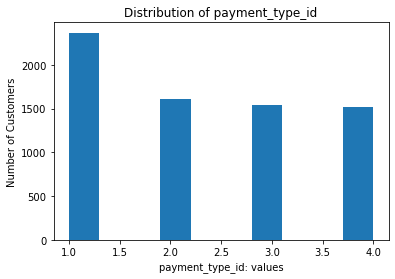

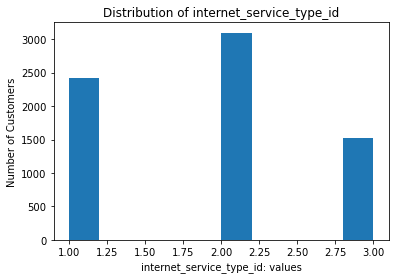

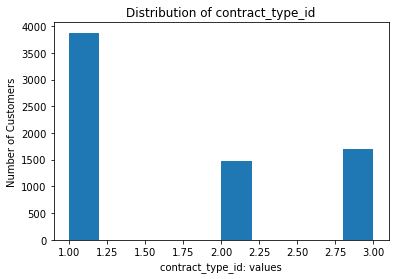

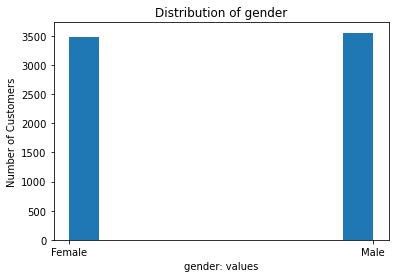

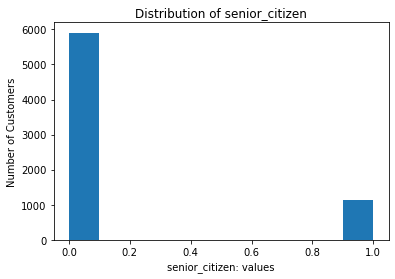

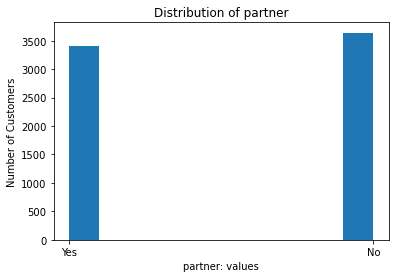

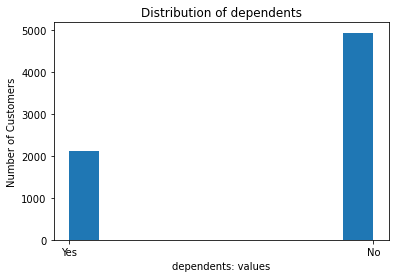

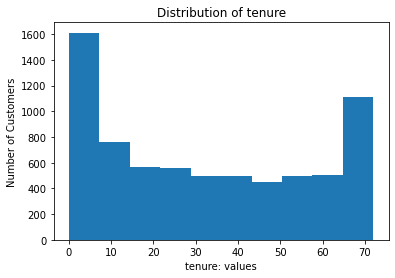

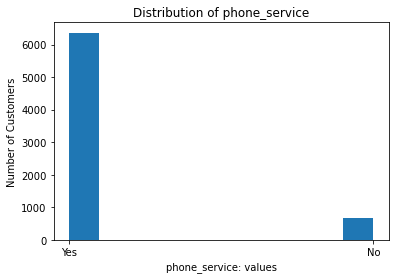

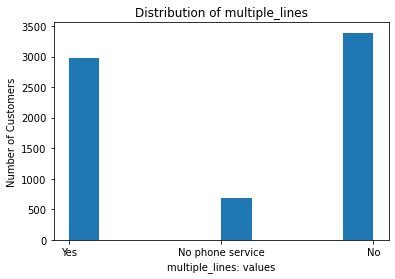

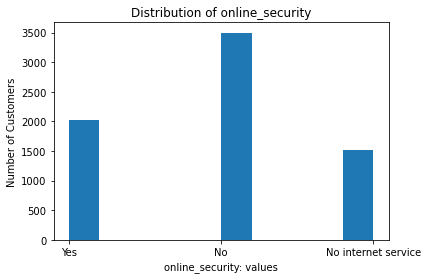

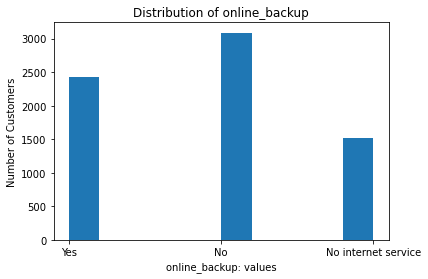

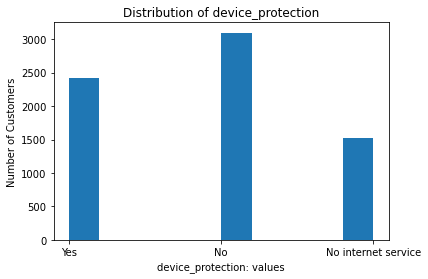

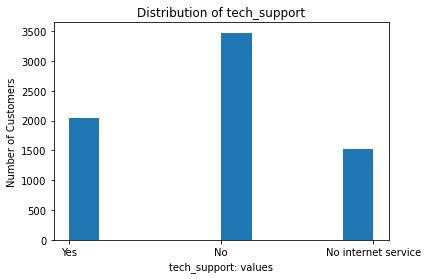

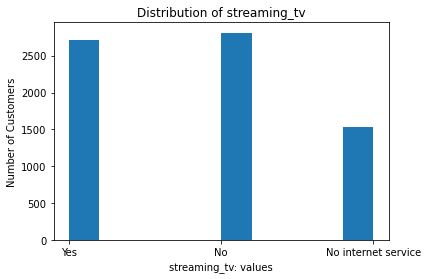

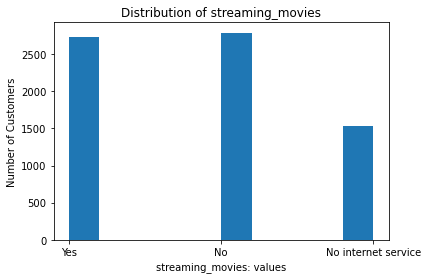

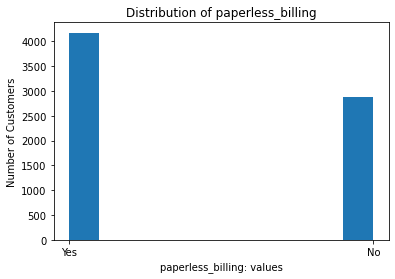

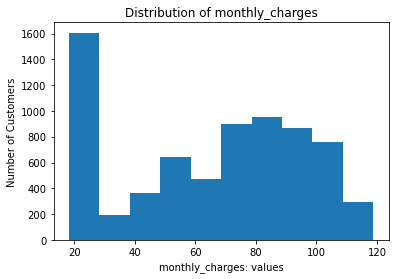

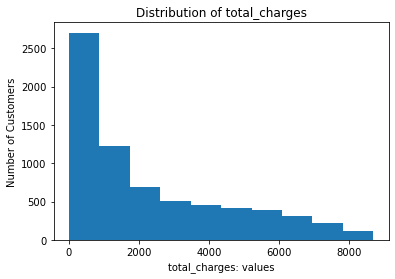

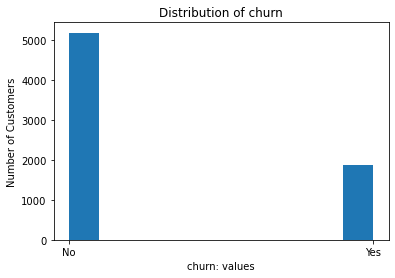

In [14]:
graph_distributions(telco_df)

In [15]:
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.90,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.10,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.40,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.20,No,Two year,DSL,Bank transfer (automatic)


In [16]:
train, validate, test = split_data(telco_df) ##using function from prepare to split data

In [17]:
train.shape, validate.shape, test.shape ##making sure shape is consistent with the normal

((3943, 24), (1691, 24), (1409, 24))

In [18]:
train.head() ##showing train df

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
5642,4,3,3,1982-FEBTD,Female,0,Yes,Yes,23,Yes,...,No internet service,No internet service,No internet service,Yes,25.60,514.75,No,Two year,None,Credit card (automatic)
3338,3,2,2,8982-NHAVY,Male,0,No,No,27,Yes,...,No,Yes,Yes,Yes,100.50,2673.45,No,One year,Fiber optic,Bank transfer (automatic)
4273,1,2,1,4115-NZRKS,Female,1,No,No,7,Yes,...,No,Yes,Yes,Yes,89.15,574.35,No,Month-to-month,Fiber optic,Electronic check
2382,3,1,1,9633-DENPU,Female,0,Yes,No,47,Yes,...,No,Yes,No,Yes,58.60,2723.40,No,Month-to-month,DSL,Bank transfer (automatic)
2655,4,2,3,5693-PIPCS,Male,0,No,No,41,Yes,...,Yes,Yes,Yes,Yes,99.65,4220.35,No,Two year,Fiber optic,Credit card (automatic)


In [19]:
validate.head() ##showing validate df

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
1630,2,1,1,3668-QPYBK,Male,0,No,No,2,Yes,...,No,No,No,Yes,53.85,108.15,Yes,Month-to-month,DSL,Mailed check
5181,1,2,1,8380-PEFPE,Male,0,No,Yes,1,Yes,...,No,No,No,Yes,71.65,71.65,Yes,Month-to-month,Fiber optic,Electronic check
4239,3,2,1,3956-CJUST,Female,1,No,No,23,Yes,...,No,No,No,Yes,75.40,1643.55,No,Month-to-month,Fiber optic,Bank transfer (automatic)
5814,2,3,3,4652-ODEVH,Male,0,Yes,Yes,45,Yes,...,No internet service,No internet service,No internet service,No,24.45,1088.25,No,Two year,None,Mailed check
1438,3,1,1,2100-BDNSN,Female,0,Yes,No,5,Yes,...,Yes,Yes,No,No,67.95,350.30,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [20]:
test.head() ## show test df

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2789,3,2,3,8670-ERCJH,Male,0,No,No,72,Yes,...,Yes,Yes,Yes,No,113.40,8164.10,No,Two year,Fiber optic,Bank transfer (automatic)
1233,3,1,1,0356-ERHVT,Male,0,Yes,No,11,Yes,...,No,No,No,Yes,45.90,521.90,No,Month-to-month,DSL,Bank transfer (automatic)
6784,2,3,1,4786-UKSNZ,Male,0,No,No,1,Yes,...,No internet service,No internet service,No internet service,No,20.20,20.20,Yes,Month-to-month,None,Mailed check
3177,1,2,2,5945-AZYHT,Male,0,Yes,No,71,Yes,...,No,Yes,Yes,Yes,109.60,7854.15,No,One year,Fiber optic,Electronic check
1740,2,1,1,4432-ADRLB,Male,0,No,No,2,Yes,...,No,No,No,No,44.65,74.90,Yes,Month-to-month,DSL,Mailed check


## Explore & Hypothesis

In [21]:
cols2 = ['payment_type_id', ## making new column list to display boxplots to help with
 'gender',                  ## forming statistcal analysis questions
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',]

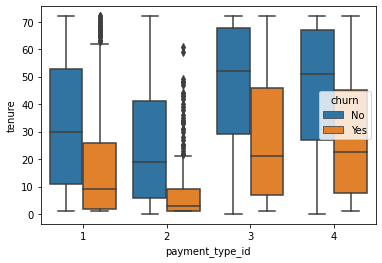

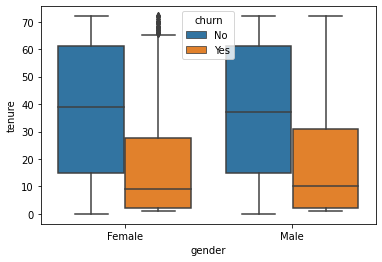

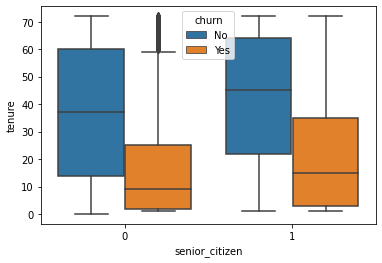

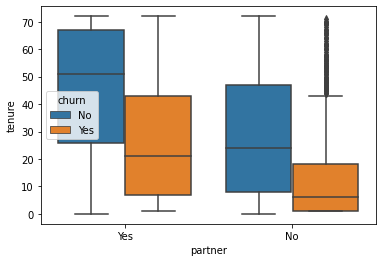

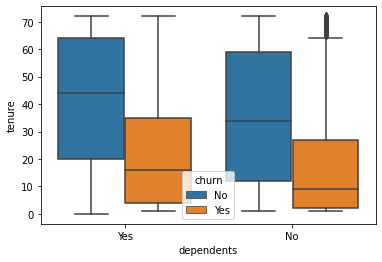

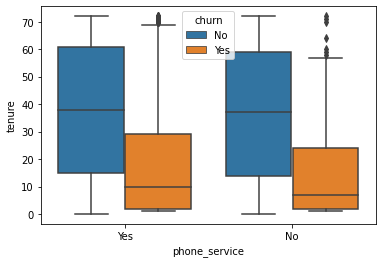

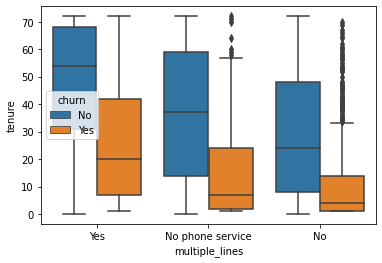

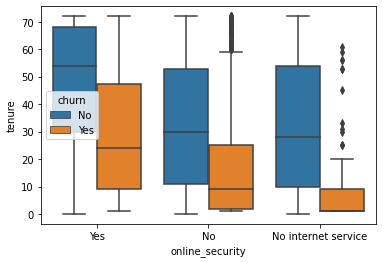

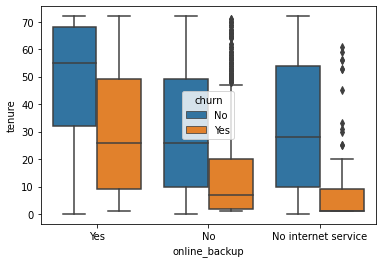

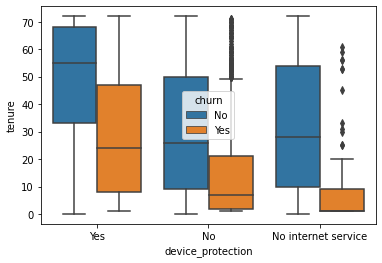

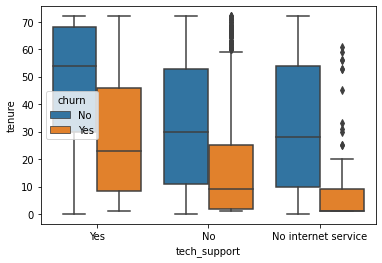

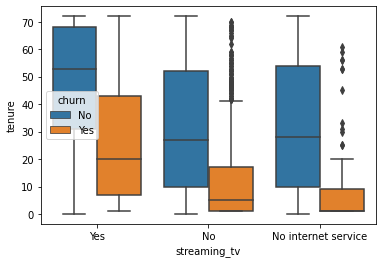

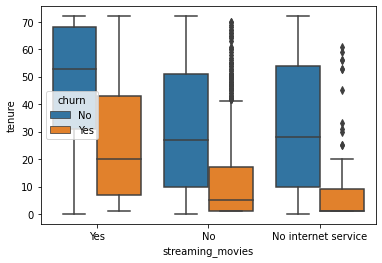

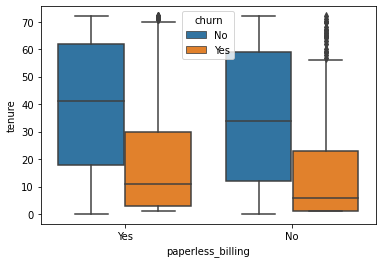

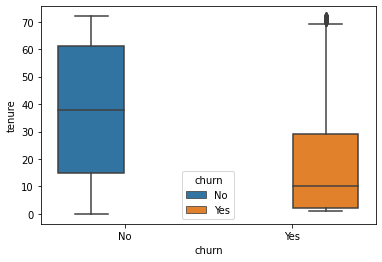

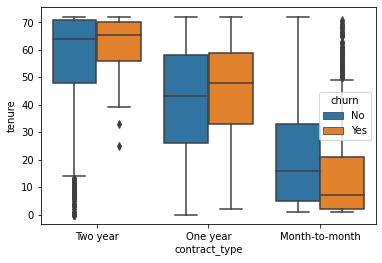

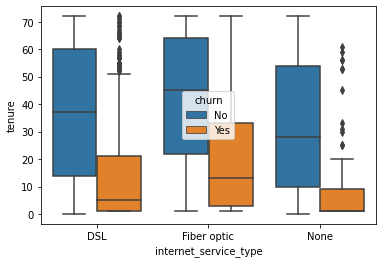

In [22]:
for col in cols2:  ### looking at box plots of tenure vs all the columns with churn
                ### as a hue to determine what questions I would like to ask for my 
        ### statistical analysis
    sns.boxplot(data = telco_df, x= col, y='tenure', hue = 'churn') 
    plt.show()

### Question 1: Is there a relationship between customers with paperless billing and whether or not they churned

In [23]:
alpha = 0.5

##### $H_0$: There is no relationship between paperless billing and whether or not a customer has churned

##### $H_a$: There is a relationship between paperless billing customers and whether or not they have churned

In [24]:
telco_num = convert_cats(telco_df) ##converting dataframe to numerical dataframe for computer format
telco_num.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,9,0,0,1,1,65,1,...,2,2,2,1,90.45,5957.90,0,2,0,3
1,4,1,3,10,1,0,0,0,54,0,...,2,2,0,0,45.20,2460.55,0,2,0,1
2,3,1,3,14,0,0,0,0,56,0,...,2,0,0,0,45.05,2560.10,0,2,0,0
3,4,1,3,34,1,0,1,1,20,0,...,2,0,0,1,39.40,825.40,0,2,0,1
4,3,1,3,45,1,0,1,0,72,1,...,2,2,2,1,85.15,6316.20,0,2,0,0


In [26]:
observed = pd.crosstab(telco_num.paperless_billing, telco_num.churn)

## ^making a crosstab of the observed values for the chi^2 test. (paperless_billing and churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

## ^ performing the test on observed and outputting results
print('Observed\n')
print(observed)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

churn                 0     1
paperless_billing            
0                  2403   469
1                  2771  1400
---
Expected

[[2109.85773108  762.14226892]
 [3064.14226892 1106.85773108]]
---

chi^2 = 258.2776
p     = 0.0000


#### Given our p value is less than our alpha (0.5) and is nearly approaching 0 we can reject our null hypothesis and same there is a significant relationship between paperless billing and whether or not a customer has churned

### Question 2: Is there a relationship between if a customer has multiple lines and whether or not they have churned

In [27]:
alpha = 0.5

##### $H_0$: There is no relationship between customers having multiple lines and whether or not they have churned

##### $H_a$: There is a relationship between customers having multiple lines and whether or not they have churned


In [28]:
observed = pd.crosstab(telco_num.multiple_lines, telco_num.churn)

## ^making a crosstab of the observed values for the chi^2 test. (paperless_billing and churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

## ^ performing the test on observed and outputting results
print('Observed\n')
print(observed)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

churn              0    1
multiple_lines           
0               2541  849
1                512  170
2               2121  850
---
Expected

[[2490.39613801  899.60386199]
 [ 501.01774812  180.98225188]
 [2182.58611387  788.41388613]]
---

chi^2 = 11.3304
p     = 0.0035


#### Given our p value is less than our alpha (0.5) and is 0.0035 we can reject our null hypothesis and same there is a significant relationship between the multiple line customer data and whether or not they have churned

## Feature Engineering

In [254]:
telco_num.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,baseline
0,2,1,3,9,0,0,1,1,65,1,...,2,2,1,90.45,5957.90,0,2,0,3,0
1,4,1,3,10,1,0,0,0,54,0,...,2,0,0,45.20,2460.55,0,2,0,1,0
2,3,1,3,14,0,0,0,0,56,0,...,0,0,0,45.05,2560.10,0,2,0,0,0
3,4,1,3,34,1,0,1,1,20,0,...,0,0,1,39.40,825.40,0,2,0,1,0
4,3,1,3,45,1,0,1,0,72,1,...,2,2,1,85.15,6316.20,0,2,0,0,0


In [291]:
telco_num['fiber'] = np.where(telco_num.internet_service_type == 2, 1, 0)
telco_num['month_to_month'] = np.where(telco_num.contract_type_id == 1, 1, 0)

In [292]:
telco_num.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,baseline,fiber,month_to_month
0,2,1,3,9,0,0,1,1,65,1,...,1,90.45,5957.90,0,2,0,3,0,0,0
1,4,1,3,10,1,0,0,0,54,0,...,0,45.20,2460.55,0,2,0,1,0,0,0
2,3,1,3,14,0,0,0,0,56,0,...,0,45.05,2560.10,0,2,0,0,0,0,0
3,4,1,3,34,1,0,1,1,20,0,...,1,39.40,825.40,0,2,0,1,0,0,0
4,3,1,3,45,1,0,1,0,72,1,...,1,85.15,6316.20,0,2,0,0,0,0,0


In [293]:
train, validate, test = split_data(telco_num)

In [294]:
train.shape, validate.shape, test.shape

((3943, 27), (1691, 27), (1409, 27))

In [264]:
train.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,baseline,fiber
5642,4,3,3,1332,0,0,1,1,23,1,...,1,1,25.60,514.75,0,2,2,1,0,1
3338,3,2,2,6343,1,0,0,0,27,1,...,2,1,100.50,2673.45,0,1,1,0,0,0
4273,1,2,1,2887,0,1,0,0,7,1,...,2,1,89.15,574.35,0,0,1,2,0,0
2382,3,1,1,6787,0,0,1,0,47,1,...,0,1,58.60,2723.40,0,0,0,0,0,0
2655,4,2,3,4037,1,0,0,0,41,1,...,2,1,99.65,4220.35,0,2,1,1,0,0


## Model Building & Evaluation

#### Determining Baseline Accuracy

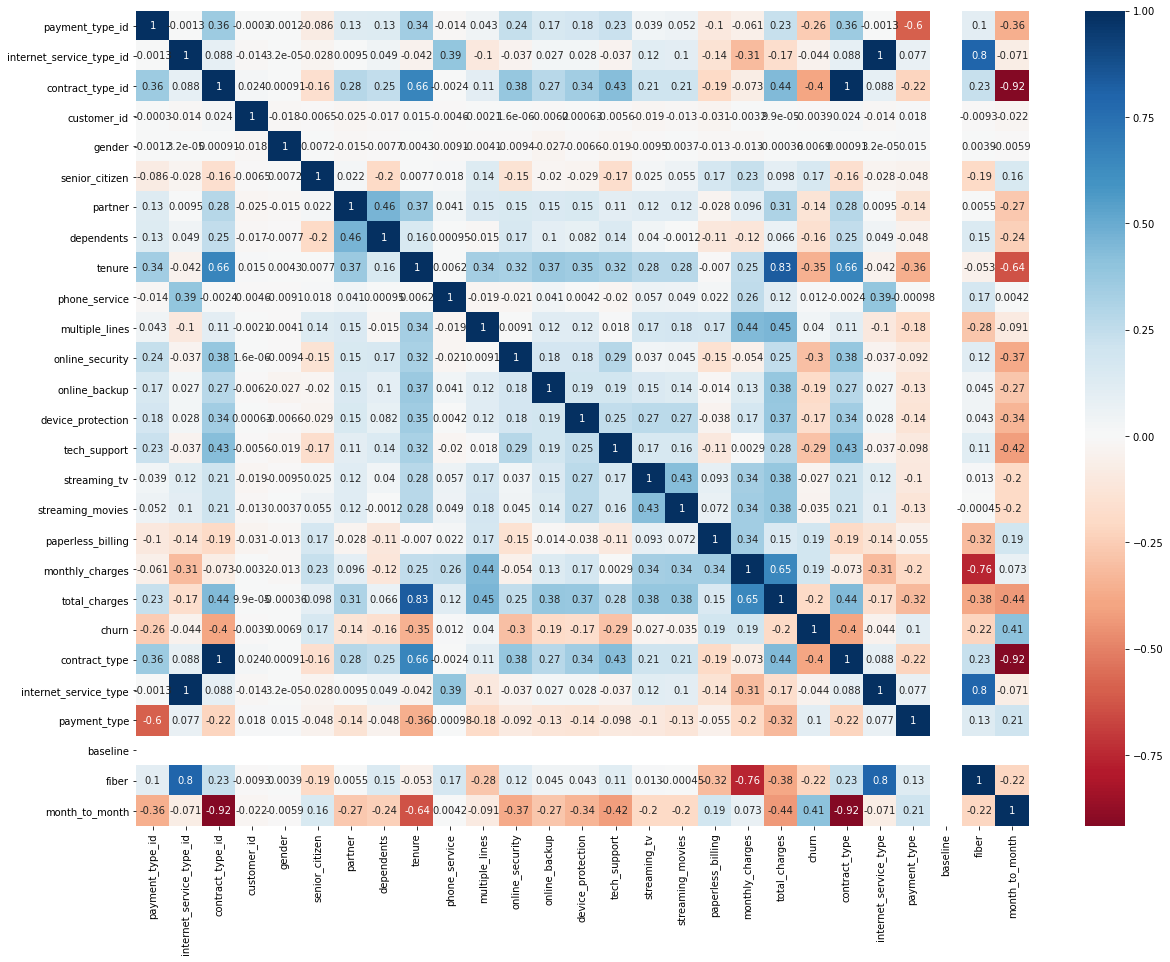

In [295]:
plt.figure(figsize = (20,15))  ##making a heap map to look at correlations with churn for the train data set
sns.heatmap(train.corr(), cmap ='RdBu', center = 0, annot = True)
plt.show()                    ## helping me choose which features to use in my model

In [30]:
telco_df.churn.value_counts() ## doing value counts to look at what should be our baseline

0    5174
1    1869
Name: churn, dtype: int64

In [296]:
train['baseline'] = 0  ## adding a baseline column to train data set. Set to 0 because that
train.head()           ## is the most frequent value

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,baseline,fiber,month_to_month
5642,4,3,3,1332,0,0,1,1,23,1,...,1,25.60,514.75,0,2,2,1,0,1,0
3338,3,2,2,6343,1,0,0,0,27,1,...,1,100.50,2673.45,0,1,1,0,0,0,0
4273,1,2,1,2887,0,1,0,0,7,1,...,1,89.15,574.35,0,0,1,2,0,0,1
2382,3,1,1,6787,0,0,1,0,47,1,...,1,58.60,2723.40,0,0,0,0,0,0,1
2655,4,2,3,4037,1,0,0,0,41,1,...,1,99.65,4220.35,0,2,1,1,0,0,0


In [37]:
## label encoding my train, test, and split to numeric format
train = convert_cats(train)
validate = convert_cats(validate)
test = convert_cats(test)

/Users/forrestmccrosky/Desktop/codeup_data_science/Classification_Project/prepare.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])


In [297]:
train.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,baseline,fiber,month_to_month
5642,4,3,3,1332,0,0,1,1,23,1,...,1,25.60,514.75,0,2,2,1,0,1,0
3338,3,2,2,6343,1,0,0,0,27,1,...,1,100.50,2673.45,0,1,1,0,0,0,0
4273,1,2,1,2887,0,1,0,0,7,1,...,1,89.15,574.35,0,0,1,2,0,0,1
2382,3,1,1,6787,0,0,1,0,47,1,...,1,58.60,2723.40,0,0,0,0,0,0,1
2655,4,2,3,4037,1,0,0,0,41,1,...,1,99.65,4220.35,0,2,1,1,0,0,0


In [298]:
validate.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,baseline,fiber,month_to_month
1630,2,1,1,2564,1,0,0,0,2,1,...,1,53.85,108.15,1,0,0,3,0,0,1
5181,1,2,1,5943,1,0,0,1,1,1,...,1,71.65,71.65,1,0,1,2,0,0,1
4239,3,2,1,2779,0,1,0,0,23,1,...,1,75.40,1643.55,0,0,1,0,0,0,1
5814,2,3,3,3252,1,0,1,1,45,1,...,0,24.45,1088.25,0,2,2,3,0,1,0
1438,3,1,1,1425,0,0,1,0,5,1,...,0,67.95,350.30,1,0,0,0,0,0,1


In [299]:
test.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,baseline,fiber,month_to_month
2789,3,2,3,6121,1,0,0,0,72,1,...,0,113.40,8164.10,0,2,1,0,0,0,0
1233,3,1,1,229,1,0,1,0,11,1,...,1,45.90,521.90,0,0,0,0,0,0,1
6784,2,3,1,3357,1,0,0,0,1,1,...,0,20.20,20.20,1,0,2,3,0,1,1
3177,1,2,2,4210,1,0,1,0,71,1,...,1,109.60,7854.15,0,1,1,2,0,0,0
1740,2,1,1,3093,1,0,0,0,2,1,...,0,44.65,74.90,1,0,0,3,0,0,1


In [269]:
## calculating a baseline accuracy
base_acc = (train.baseline == train.churn).mean()
print(f'The baseline accuracy is: {base_acc:.4f}')

The baseline accuracy is: 0.7347


In [116]:
# Function for model performs. move to explore.py
def model_performs (X_df, y_df, model):
    '''
    Take in a X_df, y_df and model  and fit the model , make a prediction, calculate score (accuracy), 
    confusion matrix, rates, clasification report.
    X_df: train, validate or  test. Select one
    y_df: it has to be the same as X_df.
    model: name of your model that you prevously created 

    '''

    #prediction
    pred = model.predict(X_df)

    #score = accuracy
    acc = model.score(X_df, y_df)

    #conf Matrix
    conf = confusion_matrix(y_df, pred)
    mat =  pd.DataFrame ((confusion_matrix(y_df, pred )),index = ['actual_not_churned','actual_churned'], columns =['pred_not_churned','pred_churned' ])
    rubric_df = pd.DataFrame([['True Negative', 'False positive'], ['False Negative', 'True Positive']], columns=mat.columns, index=mat.index)
    cf = rubric_df + ': ' + mat.values.astype(str)

    #assign the values
    tp = conf[1,1]
    fp =conf[0,1] 
    fn= conf[1,0]
    tn =conf[0,0]

    #calculate the rate
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr = tn/(tn+fp)
    fnr = fn/(fn+tp)

    #classification report
    clas_rep =pd.DataFrame(classification_report(y_df, pred, output_dict=True)).T
    clas_rep.rename(index={'0': "not churned", '1': "churned"}, inplace = True)
    print(f'''
    The accuracy for our model is {acc:.4%}

    The True Positive Rate is {tpr:.3%},    The False Positive Rate is {fpr:.3%},
    The True Negative Rate is {tnr:.3%},    The False Negative Rate is {fnr:.3%}

    ________________________________________________________________________________
    ''')
    print('''
    The positive is  'churned'

    Confusion Matrix
    ''')
    display(cf)
    print('''

    ________________________________________________________________________________
    
    Classification Report:
    ''')
    display(clas_rep)

In [300]:
##set up X and Ys
cols = ['tenure', 'monthly_charges', 'fiber', 'month_to_month']


X_train, y_train = train[cols], train.churn
X_validate, y_validate = validate[cols], validate.churn
X_test, y_test = test[cols], test.churn

model = DecisionTreeClassifier(random_state = 123, max_depth = 3)
model.fit(X_train, y_train)

model_performs(X_train, y_train, model)


    The accuracy for our model is 78.6457%

    The True Positive Rate is 29.637%,    The False Positive Rate is 3.659%,
    The True Negative Rate is 96.341%,    The False Negative Rate is 70.363%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 2791,False positive: 106
actual_churned,False Negative: 736,True Positive: 310




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.791324,0.963410,0.868929,2897.000000
churned,0.745192,0.296367,0.424077,1046.000000
accuracy,0.786457,0.786457,0.786457,0.786457
macro avg,0.768258,0.629889,0.646503,3943.000000
weighted avg,0.779086,0.786457,0.750918,3943.000000


In [309]:
## running validate report 
model_performs(X_validate, y_validate, model)


    The accuracy for our model is 78.2969%

    The True Positive Rate is 29.621%,    The False Positive Rate is 4.106%,
    The True Negative Rate is 95.894%,    The False Negative Rate is 70.379%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1191,False positive: 51
actual_churned,False Negative: 316,True Positive: 133




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.790312,0.958937,0.866497,1242.000000
churned,0.722826,0.296214,0.420221,449.000000
accuracy,0.782969,0.782969,0.782969,0.782969
macro avg,0.756569,0.627576,0.643359,1691.000000
weighted avg,0.772393,0.782969,0.748000,1691.000000


#### Takeaways from Decision Tree Classifier
    -Given the high percentages within the performance report for the train dataset but the low percentages in the validate report. We can determine this model is overfit and we should look at testing other models or adjusting features before moving on to the test dataset.

## Random Forest Model

In [312]:
forest_model = RandomForestClassifier(max_depth = 3, max_leaf_nodes = 10)
forest_model.fit(X_train, y_train)

model_performs(X_train, y_train, forest_model)


    The accuracy for our model is 79.2797%

    The True Positive Rate is 37.667%,    The False Positive Rate is 5.696%,
    The True Negative Rate is 94.304%,    The False Negative Rate is 62.333%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 2732,False positive: 165
actual_churned,False Negative: 652,True Positive: 394




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.807329,0.943045,0.869925,2897.000000
churned,0.704830,0.376673,0.490966,1046.000000
accuracy,0.792797,0.792797,0.792797,0.792797
macro avg,0.756079,0.659859,0.680445,3943.000000
weighted avg,0.780138,0.792797,0.769395,3943.000000


In [314]:
model_performs(X_validate, y_validate, forest_model)


    The accuracy for our model is 78.7700%

    The True Positive Rate is 37.639%,    The False Positive Rate is 6.361%,
    The True Negative Rate is 93.639%,    The False Negative Rate is 62.361%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1163,False positive: 79
actual_churned,False Negative: 280,True Positive: 169




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.805960,0.936393,0.866294,1242.0000
churned,0.681452,0.376392,0.484935,449.0000
accuracy,0.787700,0.787700,0.787700,0.7877
macro avg,0.743706,0.656392,0.675615,1691.0000
weighted avg,0.772900,0.787700,0.765035,1691.0000


#### Takeaways from Random Forest Classifier
    -Given the high percentages within the performance report for the train dataset but the low percentages in the validate report. We can determine this model is overfit and we should look at testing other models or adjusting features before moving on to the test dataset.

## KNN Model 

In [320]:
knn_model = KNeighborsClassifier(n_neighbors = 32)
knn_model.fit(X_train, y_train)
model_performs(X_train, y_train, knn_model)


    The accuracy for our model is 79.7616%

    The True Positive Rate is 43.021%,    The False Positive Rate is 6.973%,
    The True Negative Rate is 93.027%,    The False Negative Rate is 56.979%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 2695,False positive: 202
actual_churned,False Negative: 596,True Positive: 450




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.818900,0.930273,0.871041,2897.000000
churned,0.690184,0.430210,0.530035,1046.000000
accuracy,0.797616,0.797616,0.797616,0.797616
macro avg,0.754542,0.680242,0.700538,3943.000000
weighted avg,0.784754,0.797616,0.780579,3943.000000


In [321]:
model_performs(X_validate, y_validate, knn_model)


    The accuracy for our model is 79.7161%

    The True Positive Rate is 43.207%,    The False Positive Rate is 7.085%,
    The True Negative Rate is 92.915%,    The False Negative Rate is 56.793%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1154,False positive: 88
actual_churned,False Negative: 255,True Positive: 194




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.819021,0.929147,0.870615,1242.000000
churned,0.687943,0.432071,0.530780,449.000000
accuracy,0.797161,0.797161,0.797161,0.797161
macro avg,0.753482,0.680609,0.700697,1691.000000
weighted avg,0.784216,0.797161,0.780381,1691.000000


#### Takeaways from KNN Model Classifier
    -Given the high percentages within the performance report for the train dataset but the low percentages in the validate report. We can determine this model is overfit and we should look at testing other models or adjusting features before moving on to the test dataset.

In [306]:
logic_model = LogisticRegression(random_state = 123)
logic_model.fit(X_train, y_train)

model_performs(X_train, y_train, logic_model)


    The accuracy for our model is 78.6457%

    The True Positive Rate is 49.904%,    The False Positive Rate is 10.977%,
    The True Negative Rate is 89.023%,    The False Negative Rate is 50.096%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 2579,False positive: 318
actual_churned,False Negative: 524,True Positive: 522




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.831131,0.890231,0.859667,2897.000000
churned,0.621429,0.499044,0.553552,1046.000000
accuracy,0.786457,0.786457,0.786457,0.786457
macro avg,0.726280,0.694638,0.706610,3943.000000
weighted avg,0.775501,0.786457,0.778461,3943.000000


In [317]:
model_performs(X_validate, y_validate, logic_model)


    The accuracy for our model is 78.3560%

    The True Positive Rate is 48.998%,    The False Positive Rate is 11.031%,
    The True Negative Rate is 88.969%,    The False Negative Rate is 51.002%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1105,False positive: 137
actual_churned,False Negative: 229,True Positive: 220




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.828336,0.889694,0.857919,1242.00000
churned,0.616246,0.489978,0.545906,449.00000
accuracy,0.783560,0.783560,0.783560,0.78356
macro avg,0.722291,0.689836,0.701912,1691.00000
weighted avg,0.772021,0.783560,0.775072,1691.00000
